In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import matplotlib.patches as patches
#import seaborn as sns
from collections import Counter
import os
import random
import xml.etree.ElementTree as ET
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset,DataLoader
from PIL import Image

import sys
import torch.optim as optim
from tqdm.notebook import tqdm

#import xmltodict

In [2]:
device = torch.device ("cuda:0" if torch.cuda.is_available () else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def xml_transform(xml_path):
    xml = ET.parse(xml_path)
    root = xml.getroot()
    img_name = root[1].text
    labels, boxes = [], [] 
    
    for obj in root.iter('object'):
        label = obj[0].text
        labels.append(label)
        box = [int(coord.text) for coord in obj[4]]
        boxes.append(box)
    target = {'boxes' : torch.as_tensor(boxes, dtype=torch.float32),
              'labels' : labels}
    return img_name, target

def count_classes(path_annotations):
    target_list = []
    xml_list = [os.path.join(path_annotations, file) for file in os.listdir(path_annotations)]
    for xml in xml_list:
        _, target = xml_transform(xml)
        target_list += target['labels']
    return Counter(target_list) 
    

In [12]:
path_annotations = "/content/drive/MyDrive/birds/annotations/" 
images_dir = "/content/drive/MyDrive/birds/"

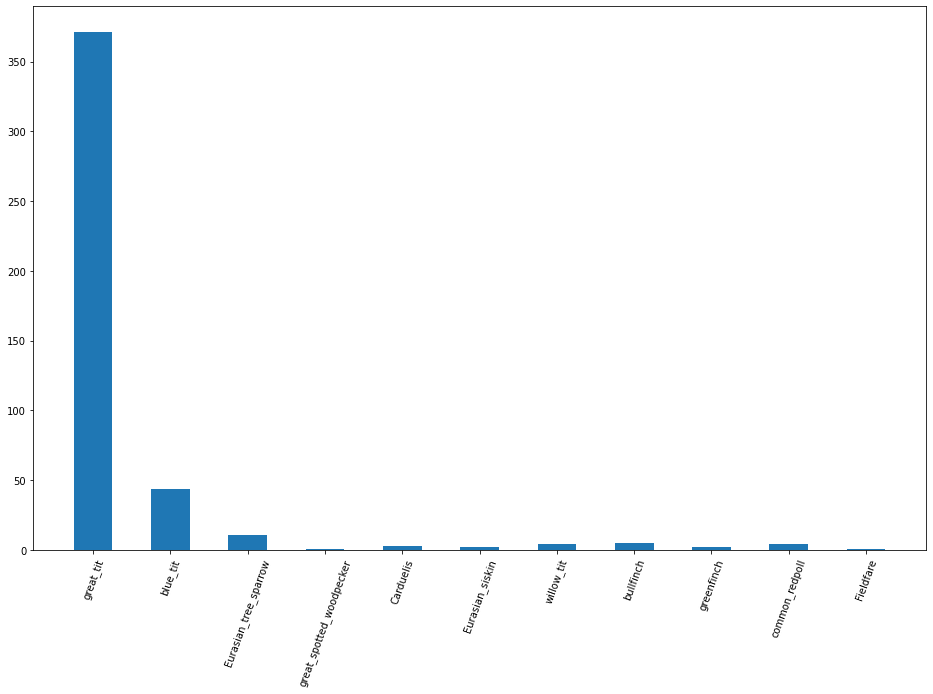

In [13]:
#class distribution

labels, values = zip(*count_classes(path_annotations).items())

#labels_dict = { i+1:label for i,label in enumerate(labels)}# labels dictionary


indexes = np.arange(len(labels))
width = 0.5
plt.figure(figsize = (16,10))
plt.bar(indexes, values, width, align='edge')
plt.xticks(indexes + width * 0.5, labels, rotation=70)
plt.show()

In [14]:
labels_dict = {1: 'Eurasian_jay',
 2: 'great_spotted_woodpecker',
 3: 'greenfinch',
 4: 'blue_tit',
 5: 'Carduelis',
 6: 'common_redpoll',
 7: 'great_tit',
 8: 'bullfinch',
 9: 'Eurasian_siskin',
 10: 'Eurasian_tree_sparrow',
 11: 'hawfinch',
 12: 'willow_tit',
 13: 'Fieldfare',
 14: 'Common chaffinch'}
n_classes = len(labels_dict)  # number of classes

In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))


In [16]:
def train_val_split(path_annotations,val_size=.25, seed=773):
    random.seed(seed)
    path_list = [os.path.join(path_annotations,path) for path in os.listdir(path_annotations)]
    val_size = int(len(path_list)*val_size)
    val_paths = random.sample(path_list,val_size)
    train_paths = list(set(path_list) - set(val_paths)) 
    return train_paths, val_paths
    

In [ ]:
def plot_detection(img, info, with_text=False, conf_lvl=0.3, swap=True):
    fig, ax = plt.subplots()
    img = img.permute((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img.numpy() + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    img = np.clip(img, 0, 1)
    #color_dict = {3: 'red', 1: 'green', 2: 'yellow'}
    if swap:
        img = img.swapaxes(0,1)
        img = img.swapaxes(1,2)
        img = np.clip(img, 0, 1)
    ax.imshow(img)
    flag = False
    if 'scores' in info.keys():
        mask = info['scores'] >= conf_lvl
        confidences = info['scores'][mask]
        boxes = info['boxes'][mask]
        labels = info['labels'][mask]
        
        flag = True
    else:
        
        boxes = info['boxes']
        labels = info['labels']

    
    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = box
        height = y_max - y_min
        width = x_max - x_min
        
        label = labels_dict [int(labels[i])]
        #color = color_dict[int(labels[i])]
        rect = patches.Rectangle((x_min, y_min), width, height,
                                 linewidth=2, edgecolor="red",
                                 facecolor='none')
        ax.add_patch(rect)
        if with_text:
            if flag:
                text = '{} {:.0f}%'.format(label, confidences[i]*100)
            else:
                text = '{}'.format(label)
            ax.text(x_min, y_min, text,
                    bbox=dict(facecolor='white', alpha=0.5))
    plt.show()


In [73]:
train_transform = transforms.Compose([
                            transforms.ToTensor(),
                            
                            #transforms.Grayscale(),
                            transforms.ColorJitter(brightness=.5, hue=.3),
                            transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                            transforms.RandomInvert(),
                            #transforms.RandomPosterize(bits=2),
                            transforms.RandomSolarize(threshold=192.0),
                            transforms.RandomAdjustSharpness(sharpness_factor=2),
                            transforms.RandomAutocontrast(),
                            #transforms.RandomEqualize(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),

                        ])

val_transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ])

In [74]:
class BirdsDataset(torch.utils.data.Dataset):
    def __init__(self,transform,annotation_paths,images_dir):
        self.transform = transform
        self.annotation_paths = annotation_paths
        self.images_dir = images_dir
        
    def __len__(self):
        return len(self.annotation_paths)
    
    def __getitem__(self,idx):
        path = self.annotation_paths[idx]
        img_name, target = xml_transform(path)
        target['labels'] = [list(labels_dict.keys())[list(labels_dict.values()).index(label)] for label in target['labels']]
        target['labels']  = torch.as_tensor(target['labels'], dtype=torch.int64) 
        img_path = os.path.join(self.images_dir,img_name)
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        
        return img, target
        
        
        

In [75]:
batch_size = 2
val_size = 0.25
train_ann_path, val_ann_path = train_val_split(path_annotations,val_size=val_size,seed=779)

train_dataset = BirdsDataset(transform=train_transform,
                            annotation_paths = train_ann_path,
                            images_dir  = images_dir)

val_dataset = BirdsDataset(transform=val_transform,
                            annotation_paths = val_ann_path,
                            images_dir  = images_dir)

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size,shuffle = True,
                                            collate_fn=collate_fn)

val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = True,
                                            collate_fn=collate_fn)

dataloaders = {'train': train_batch_gen,
               'val': val_batch_gen}

dataset_sizes = {'train' : len(train_dataset),
                 'val' : len(val_dataset)}

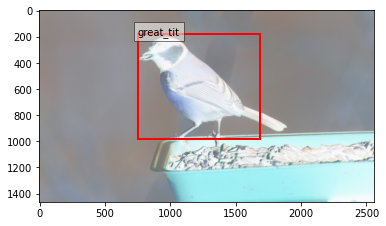

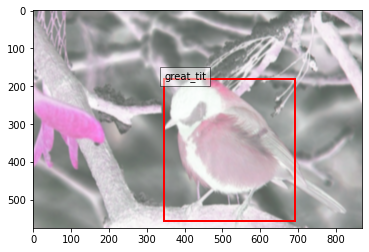

In [76]:
imgs, boxes= next(iter(train_batch_gen))
for img, info in zip(imgs, boxes):
    plot_detection(img, info, with_text=True,swap = False)


## Model and training


In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

#load Faster R-CNN pre-trained on COCO dataset
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#Change the classifier head with a new one:
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = n_classes+1 #(n_classes + background)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = model.to(device)

Starting epoch 0


  0%|          | 0/735 [00:00<?, ?it/s]

/home/costia/anaconda3/envs/DL/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


All bounding boxes should have positive height and width. Found invalid box [677.1583251953125, 719.3342895507812, 677.1583251953125, 726.3635864257812] for target at index 0.


  0%|          | 0/245 [00:00<?, ?it/s]

Starting epoch 1


  0%|          | 0/735 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [677.1583251953125, 719.3342895507812, 677.1583251953125, 726.3635864257812] for target at index 1.


  0%|          | 0/245 [00:00<?, ?it/s]

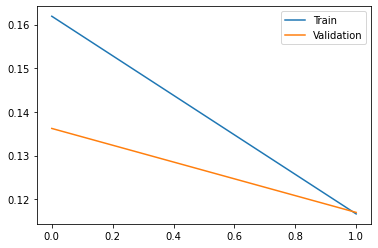

Starting epoch 2


  0%|          | 0/735 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [677.1583251953125, 719.3342895507812, 677.1583251953125, 726.3635864257812] for target at index 0.


  0%|          | 0/245 [00:00<?, ?it/s]

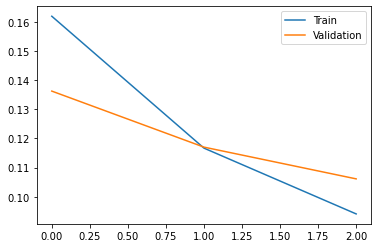

Starting epoch 3


  0%|          | 0/735 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [677.1583251953125, 719.3342895507812, 677.1583251953125, 726.3635864257812] for target at index 0.


  0%|          | 0/245 [00:00<?, ?it/s]

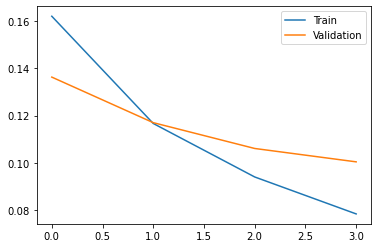

Starting epoch 4


  0%|          | 0/735 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [677.1583251953125, 719.3342895507812, 677.1583251953125, 726.3635864257812] for target at index 0.


  0%|          | 0/245 [00:00<?, ?it/s]

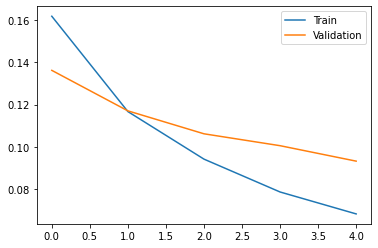

Starting epoch 5


  0%|          | 0/735 [00:00<?, ?it/s]

All bounding boxes should have positive height and width. Found invalid box [677.1583251953125, 719.3342895507812, 677.1583251953125, 726.3635864257812] for target at index 0.


  0%|          | 0/245 [00:00<?, ?it/s]

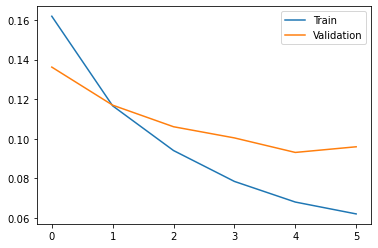

In [ ]:
number_epochs = 6   #TODO: Choose
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9)#TODO: Choose, momentum=#TODO: Choose)

train_loss = []
val_loss = []

for epoch in range(number_epochs):
    print(f"Starting epoch {epoch}")

    if epoch > 0:
        plt.figure()

    model.train()
    train_loss.append(0)
    for images, labels in tqdm(train_batch_gen):
        images = list(image.to(device) for image in images)
        labels = [{k: v.to(device) for k, v in t.items()} for t in labels]
    #print(len(images), images[0].shape, images[1].shape)
        try:
            loss_dict = model(images, labels)


        #print(type(loss_dict), len(loss_dict), loss_dict, )
        #print(loss_dict.values() )

            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step() 

        except (ValueError, RuntimeError) as e:
            print(e)
            failed_img, failed_labels = images, labels
            next

        train_loss[epoch] += losses.cpu().data
    train_loss[epoch] /= len(train_dataset)

    if epoch > 0:
        train_plt, = plt.plot(train_loss, label = 'Train')

  #TODO: compute the loss on the validation set and fill val_loss[epoch]
  #model.eval()
    val_loss.append(0)
    with torch.no_grad():
        for images, labels in tqdm(val_batch_gen):
            images = list(image.to(device) for image in images)
            labels = [{k: v.to(device) for k, v in t.items()} for t in labels]

            loss_dict = model(images, labels)
      #print(type(loss_dict), len(loss_dict), loss_dict)
            losses = sum(loss for loss in loss_dict.values())
            val_loss[epoch] += losses.cpu().data
        val_loss[epoch] /= len(val_dataset)
    

    if epoch > 0:
        val_plt, = plt.plot(val_loss, label = 'Validation')
        plt.legend(handles=[train_plt, val_plt])
        plt.show()

In [ ]:
torch.save(model.state_dict(), '/home/costia/birds/model_g2400_6_ep.pt')

In [ ]:
model.eval()
imgs, targets = next(iter(dataloaders['val']))
inputs = list(img.to(device) for img in imgs)
targets = [{k:v.to(device) for k,v in t.items()} for t in targets] 
preds = model(inputs)

for img, info in zip(imgs, preds):
    plot_detection(img, info, conf_lvl=0.5, with_text=True,swap = False)

RuntimeError: CUDA out of memory. Tried to allocate 154.00 MiB (GPU 0; 5.93 GiB total capacity; 4.29 GiB already allocated; 68.12 MiB free; 4.71 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF